# 1. Get tweets our your favorite topic and store them in a json format

In [ ]:
import json
import datetime
from twitterati import lookups

def get_tweets(hashtags: list[str]):
    for hashtag in hashtags:
        tweets = lookups.recent_search_lookup(hashtag, max_count = int(1000/len(hashtags)), period=1)
        # Append the tweets to existing json file
        with open('tweets.json', 'a') as f:
            for tweet in tweets:
                f.write(json.dumps(tweet) + '\n')
                f.flush()
            
    return tweets

get_tweets(['callofduty','warzone','vanguard','activision','mwii','mw2'])

# Read the tweets from the file

In [65]:
import pandas as pd
import numpy as np
import json
def read_tweets(file: str):
    tweets = []
    with open(file, 'r') as f:
        tweets = [json.loads(x) for x in f]

    df = pd.DataFrame({"id":[x['id'] for x in tweets],"text":[y['text'] for y in tweets]})
    return df

tweets_df = read_tweets('tweets.json')
tweets_df

,id,text
0,1554546538877071360,Call of Duty Black Ops Cold War Outbreak Live ...
1,1554546526655053826,@CallofDuty Yo we’re y’all at on that dev erro...
2,1554546516085202949,Sony time to lose call of duty\nI wat Microsof...
3,1554546492005748738,@NukaCreeper @TWIGGY_BRANCHER @CallofDuty No
4,1554546481671045126,Call of Duty: brutte notizie per il franchise ...
...,...,...
1193,1554522049028263940,Crazy Karachi shot mw2 https://t.co/klld79KUca...
1194,1554521973090402304,RT @TheCODmajority: Keeping the bring back #Ve...
1195,1554521875878973440,@Kieran_Lyon69 @MaulCKX Jure sa joue a mw2 encore
1196,1554521816256888834,@HoKageeV1 @OnlyInHalo117 @RandolphBronson @Ma...


# 2. Create the Wordcloud for tweets based on parts of speech

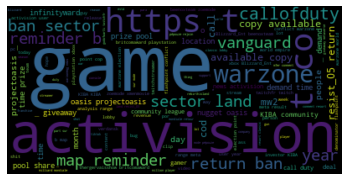

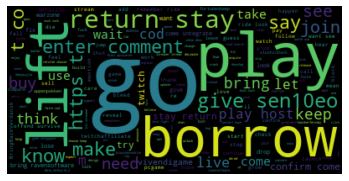

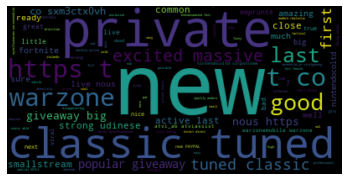

In [66]:
import spacy
import wordcloud as w

def show_wordcloud(text: list[str],
                   pos: list[str]):
    """
    A function to display a wordcloud of one or more parts of speech.
    
    :param text: The list of tweet texts
    :param pos: One or more parts of speech tags to include in the wordcloud
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(" ".join(text))
    
    for p in pos:
        phrases = [token.lemma_ for token in doc if token.pos_ == p]

        # Generate a word cloud image
        wordcloud = w.WordCloud().generate(' '.join(phrases))

        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

show_wordcloud(list(tweets_df.text), ['NOUN','VERB','ADJ'])

# 3. Construct a vector representation for each tweet in your dataset and view what this embedding space

In [67]:
import numpy as np
import spacy
import sentence_transformers
import umap
import umap.plot
import plotly.express as px

def get_tweet_embedding(text: list[str]) -> list[np.array]:
    """
    A function to embed a set of tweets into an embedding space.
    
    :param text: The list of tweet texts
    :return: The set of embedding vectors
    """
    
    model = sentence_transformers.SentenceTransformer('distilbert-base-nli-mean-tokens')

    embeddings = model.encode(text)
    
    return embeddings


In [68]:
tweet_embedding = get_tweet_embedding(list(tweets_df.text))
tweet_embedding

array([[ 0.5358737 , -0.2571572 ,  0.5649097 , ...,  0.48220628,
        -0.04196381, -0.95892465],
       [-0.35370332, -0.2535177 ,  1.1227415 , ..., -0.2326411 ,
         0.76581794,  0.08479956],
       [-0.7047295 , -0.11771972, -0.23330373, ..., -0.7858304 ,
         0.46280536,  0.21718535],
       ...,
       [-0.3908823 ,  0.01022998,  0.9739713 , ..., -0.7925975 ,
         0.3624522 , -0.6009101 ],
       [ 0.11516329, -0.23415057,  0.32578257, ..., -0.119426  ,
        -0.24978414, -0.7651253 ],
       [-0.7722245 , -0.7528108 ,  0.5031258 , ..., -0.14032054,
         0.53195566, -0.6718424 ]], dtype=float32)

In [69]:
def visualise_embedding(vectors: list[np.array]):
    """
    A function to reduce and visualise an embedding space.
    
    :param vectors: A set of vectors to visualise
    """
    mapper = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(vectors)
    #umap.plot.points(mapper) #.diagnostic(mapper, diagnostic_type='local_dim')
    fig = px.scatter(mapper)
    fig.show()
    return mapper

In [70]:
umap_embeddings = visualise_embedding(list(tweet_embedding))

# 4. Topic modelling using BERT

In [71]:
import numpy as np
import umap
import hdbscan

def get_topics(vectors: list[np.array]) -> list[list[tuple[str, float]]]:
    """
    A function to uncover the topics present in a text embedding.
    
    :param vectors: A set of embedding vectors
    :return: The uncovered topics and their associated scores
    """
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit_predict(vectors)
    
    return cluster

In [72]:
topic_cluster = get_topics(umap_embeddings)
topic_cluster

array([10, 10, 10, ..., 10, 10, 10], dtype=int64)

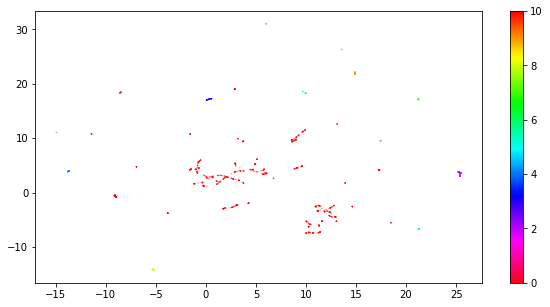

In [73]:
import matplotlib.pyplot as plt
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x','y'])
result['labels'] = topic_cluster

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [74]:
result

,x,y,labels
0,9.166835,4.592947,10
1,-0.821834,5.106392,10
2,-0.182202,1.171460,10
3,10.605371,-7.391359,10
4,12.531401,-4.408073,10
...,...,...,...
1193,9.107871,4.559998,10
1194,25.391796,3.040741,2
1195,10.432021,-5.839561,10
1196,2.174539,2.802724,10


# 5. Sentiment analysis using pretrained model

In [75]:
import transformers

def get_sentiment(text: str) -> float:
    """
    A function to predict the sentiment of a piece of text.
    
    :param text: The text
    :return: The sentiment score
    """
    
    specific_model = transformers.pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
    sentiment_score = specific_model(text)
    
    return sentiment_score

In [76]:
get_sentiment(tweets_df.text[100])

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

[{'label': 'NEU', 'score': 0.6702927350997925}]

# 6. Named Entity Recognition with Flair

In [77]:
import flair


def get_named_entities(text: str) -> list[tuple[str, str]]:
    """
    A function to identify any named entities present in a piece of text.
    
    :param text: The text
    :return: The list of entities and their associated class
    """
    named_entities = []
    # make a sentence
    sentence = flair.data.Sentence(text)
    # load the NER tagger
    tagger = flair.models.SequenceTagger.load('ner')
    # run NER over sentence
    tagger.predict(sentence)
    
    # iterate over entities and print each
    for entity in sentence.get_spans('ner'):
        named_entities.append((entity.text, entity.tag))
        
    return named_entities

In [78]:
get_named_entities(tweets_df.text[600])

C:\Users\thula\anaconda3\lib\site-packages\huggingface_hub\file_download.py:560: FutureWarning:

`cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`



2022-08-05 09:05:35,375 loading file C:\Users\thula\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-08-05 09:05:38,262 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


[('Sony', 'ORG'),
 ('Microsoft', 'ORG'),
 ('Activision', 'ORG'),
 ('Activision', 'ORG')]

# 7. Link uncovered entities to appropriate Wikipedia link

In [155]:
import requests

def link_entities(text: str) -> list[dict]:
    """
    A function to link any named entities present in a piece of text to their appropriate Wikipedia page.
    
    :param text: The text
    :return: The list of entities and their associated Wikipedia page
    """
    # Make the request
    DB_SPOTLIGHT = "https://api.dbpedia-spotlight.org/en/annotate"
    r = requests.get(DB_SPOTLIGHT, params={"text": text}, headers={"accept": "application/json"})
    # Parse response
    wiki_links = []
    for i in range(len(r.json()["Resources"])):
        entity = r.json()["Resources"][i]['@surfaceForm']
        link = r.json()["Resources"][i]['@URI']
        wiki_links.append({"entity":entity,"link":link})
    
    return wiki_links

In [158]:
link_entities(tweets_df.text[100])

[{'entity': 'Activision', 'link': 'http://dbpedia.org/resource/Activision'},
 {'entity': 'Instagram', 'link': 'http://dbpedia.org/resource/Instagram'}]

# 8. Finetune a pretrained BERT model to do text classification

In [2]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from transformers import BertTokenizerFast as BertTokenizer


# Probably a lot of copy-pasted stuff here

def predict(text: str) -> list[str]:
    """
    A function to predict the toxicity tags of a piece of text.
    
    :param text: The text
    :return: The list of toxicity tags
    """
    # Cool stuff goes here
    
    return toxicity_tags

In [4]:
#predict(tweets_df.text[100])

In [5]:
toxic_df = pd.read_csv('data/train.csv')
toxic_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(toxic_df, test_size=0.05)
train.shape, test.shape

((151592, 8), (7979, 8))

In [11]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [12]:
train[LABEL_COLUMNS].sum()

toxic            14538
severe_toxic      1517
obscene           8042
threat             456
insult            7502
identity_hate     1334
dtype: int64

In [59]:
train_toxic = train[train[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train[train[LABEL_COLUMNS].sum(axis=1) == 0]
train_toxic.shape, train_clean.shape

((10272, 8), (89728, 8))

In [60]:
train = pd.concat([
    train_toxic,
    train_clean.sample(10_000)
])

In [61]:
train[LABEL_COLUMNS].sum()

toxic            9657
severe_toxic     1024
obscene          5413
threat            295
insult           5036
identity_hate     895
dtype: int64

In [15]:
sample_row = toxic_df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment,'\n')
print(sample_labels.to_dict())

Bye! 

Don't look, come or think of comming back! Tosser. 

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [17]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt'
)


In [19]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [20]:
encoding['input_ids'].shape, encoding['attention_mask'].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [21]:
encoding['input_ids'].squeeze()[:20]

tensor([  101, 17774,   106,  1790,   112,   189,  1440,   117,  1435,  1137,
         1341,  1104,  3254,  5031,  1171,   106,  1706, 14607,   119,   102])

In [22]:
encoding['attention_mask'].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())[:20]

['[CLS]',
 'Bye',
 '!',
 'Don',
 "'",
 't',
 'look',
 ',',
 'come',
 'or',
 'think',
 'of',
 'com',
 '##ming',
 'back',
 '!',
 'To',
 '##sser',
 '.',
 '[SEP]']

In [65]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import auroc

class ToxicCommentDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int= 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        
        comment_text = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return dict(
            comment_text=comment_text,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask=encoding['attention_mask'].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [66]:
train_dataset = ToxicCommentDataset(train, tokenizer)

In [43]:
sample_item = train_dataset[0]

In [52]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0),sample_item['attention_mask'].unsqueeze(dim=0) )

In [54]:
prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 128, 768]), torch.Size([1, 768]))

In [67]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df= train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        
    def setup(self):
        self.train_dataset = ToxicCommentDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
        
        self.test_dataset = ToxicCommentDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, num_workers=4)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, num_workers=4)

In [69]:
N_EPOCHS = 10
BATCH_SIZE = 32

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

data_module =  ToxicCommentDataModule(train, test, tokenizer)
data_module.setup()

In [71]:
# Modelling information
class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )